
# Business Cases with Data Science 

## Case 2: Market Basket Analysis

#### Semester: Spring 2020
#### Group (Palm & Company) Member:
1. Pedro Santos (M20190420)
2. Ana Claudia Alferes (M20190932)
3. Lennart Dangers (M20190251)
4. Michael Machatschek (M20190054)

#### This project follows the CRISP-DM Process:

1. Business Understanding
2. Data Understanding
3. Data Preparation
4. Modelling
5. Evaluation
6. Deployment

This jupypter-notebook provides the code in python to do a market basket analysis of a given dataset. A more detailed description of this project and the solutions can be found in the report. 

# Business Understanding

Please consult our report for further details. 

# Data Understanding

## Dataset Description

A data dictionary is available in the appendix of our report.
 
 
 
 #### The following code will help to explore and understand the entire dataset. 

In [73]:
# Import packages
import csv
import pandas as pd
import numpy as np
import datetime as dt
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
import matplotlib.pyplot as plt
import networkx as nx
import plotly.offline as po 
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import itertools

In [74]:
# Load and show dataset sample (Chain of Asian Restaurant sales January 2018)
dtypes = {'DocNumber':'category','ProductDesignation':'category'}
df = pd.DataFrame(pd.read_csv("AsianRestaurant_Cyprus_2018.txt", sep=";"))

In [75]:
df.head()

,DocNumber,ProductDesignation,ProductFamily,Qty,TotalAmount,InvoiceDateHour,EmployeeID,IsDelivery,Pax,CustomerID,CustomerCity,CustomerSince
0,TKD0320000012018,1/2 DUCK,STARTERS,1.0,"27,10",2018-01-01 19:12:12.000,2,1,1,53908,LEYKOSIA,NaN
1,TKD0320000012018,SPRING ROLL,STARTERS,8.0,"17,60",2018-01-01 19:12:12.000,2,1,1,53908,LEYKOSIA,NaN
2,TKD0320000012018,SWEET SOUR CHICKEN,MEAT,2.0,"20,20",2018-01-01 19:12:12.000,2,1,1,53908,LEYKOSIA,NaN
3,TKD0320000012018,LEMON CHICKEN,MEAT,1.0,"10,10",2018-01-01 19:12:12.000,2,1,1,53908,LEYKOSIA,NaN
4,TKD0320000012018,BEEF BBS,SIZZLING,1.0,"12,60",2018-01-01 19:12:12.000,2,1,1,53908,LEYKOSIA,NaN


In [76]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84109 entries, 0 to 84108
Data columns (total 12 columns):
DocNumber             84109 non-null object
ProductDesignation    84109 non-null object
ProductFamily         84109 non-null object
Qty                   84109 non-null float64
TotalAmount           84109 non-null object
InvoiceDateHour       84109 non-null object
EmployeeID            84109 non-null int64
IsDelivery            84109 non-null int64
Pax                   84109 non-null int64
CustomerID            84109 non-null int64
CustomerCity          31248 non-null object
CustomerSince         29142 non-null object
dtypes: float64(1), int64(4), object(7)
memory usage: 7.7+ MB


In [77]:
# Convert TotalAmount to float 
df.TotalAmount = df.TotalAmount.apply(lambda x: float(x.replace(",", ".")))

In [78]:
df.isnull().sum()

DocNumber                 0
ProductDesignation        0
ProductFamily             0
Qty                       0
TotalAmount               0
InvoiceDateHour           0
EmployeeID                0
IsDelivery                0
Pax                       0
CustomerID                0
CustomerCity          52861
CustomerSince         54967
dtype: int64

In [79]:
# Create new Dataframe with orders as rows
agg_func = {"CustomerID":"first", "IsDelivery":"first", "InvoiceDateHour":"first"}
df_orders = df[["DocNumber","CustomerID", "IsDelivery", "InvoiceDateHour"]].groupby("DocNumber").aggregate(agg_func)


### Explore order frequency over time


In [80]:
df_orders["Day"] =pd.DatetimeIndex(df_orders.InvoiceDateHour).day #most frequent days 
df_orders["Hour"] = pd.DatetimeIndex(df_orders.InvoiceDateHour).hour #most frequent request hours 
df_orders["Month"] = pd.DatetimeIndex(df_orders.InvoiceDateHour).month #most frequent request months 

# Split into restaurant orders and deliveries
df_rest = df_orders[df_orders.IsDelivery == 0] 
df_deli = df_orders[df_orders.IsDelivery == 1] 

fig = make_subplots(3,2, subplot_titles=["Restaurant", "Delivery"])

fig.add_trace(go.Histogram(x=df_rest.Hour,nbinsx=24, name="Restaurant Hour"),1,1)
fig.add_trace(go.Histogram(x=df_deli.Hour,nbinsx=24, name="Delivery Hour"),1,2)

fig.add_trace(go.Histogram(x=df_rest.Day,nbinsx=31, name="Restaurant Day"),2,1)
fig.add_trace(go.Histogram(x=df_deli.Day,nbinsx=31, name="Delivery Day"),2,2)

fig.add_trace(go.Histogram(x=df_rest.Month,nbinsx=12, name="Restaurant Month"),3,1)
fig.add_trace(go.Histogram(x=df_deli.Month,nbinsx=12, name="Delivery Month"),3,2)

fig.update_xaxes(title_text="Hour", row=1, col=1)
fig.update_xaxes(title_text="Hour", row=1, col=2)
fig.update_xaxes(title_text="Day", row=2, col=1)
fig.update_xaxes(title_text="Day", row=2, col=2)
fig.update_xaxes(title_text="Month", row=3, col=1)
fig.update_xaxes(title_text="Month", row=3, col=2)

fig.update_layout(title_text="Number of orders over time", plot_bgcolor="white", showlegend=False)

fig.show() 

In the first row we can see that we have typical lunch and dinner time orders. In both, restaurant and delivery, we have considerably more orders during dinner time. *The distinction between orders during lunch time and dinner time will be used to segment the customers for our proposed recommendation system.*

In the second row we see is the frequency distribution of orders on specific days of the month. In this visualization we do not see any useful pattern for our further analysis. 

In the last row you can see the amount of orders in each month. Here we can see that in both channels, but especially in delivery, the summer is characterized by less orders. 

### Explore product family popularity in restaurants and deliveries

In [81]:
#ProductFamily Consumption in restaurant 
pf_rest= df[df.IsDelivery == 0][["ProductFamily","Qty"]].groupby(["ProductFamily"]).sum().sort_values(by = "Qty", ascending = False).reset_index() 

#ProductFamily Consumption in deliveries excluding delivery charges
pf_deli= df[df.ProductDesignation != "DELIVERY CHARGE"][df.IsDelivery == 1][["ProductFamily","Qty"]].groupby(["ProductFamily"]).sum().sort_values(by = "Qty", ascending = False).reset_index() 

pf_group = pf_rest.merge(pf_deli, left_on= "ProductFamily", right_on="ProductFamily" ) 
 
fig = go.Figure(data=[ 
    go.Bar(name='Restaurant', x=pf_group['ProductFamily'], y=pf_group['Qty_x']), 
    go.Bar(name='Deliveries', x=pf_group['ProductFamily'], y=pf_group['Qty_y']) 
]) 

# Change the bar mode 
fig.update_layout(barmode="group",height=500, width=1000, title_text="Bestselling product families - absolute values", plot_bgcolor="white")
fig.show() 


/Users/anaalferes/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



In [82]:
#ProductFamily Consumption in restaurant proportions
sum_qty_rest = sum(pf_rest.Qty.values)
pf_rest["prop"] = pf_rest["Qty"].apply(lambda x: x/sum_qty_rest)

#ProductFamily Consumption in deliveries proportions
sum_qty_deli = sum(pf_deli.Qty.values)
pf_deli["prop"] = pf_deli["Qty"].apply(lambda x: x/sum_qty_deli)

pf_group = pf_rest.merge(pf_deli, left_on= "ProductFamily", right_on="ProductFamily" ) 
 
fig = go.Figure(data=[ 
    go.Bar(name='Restaurant', x=pf_group['ProductFamily'], y=pf_group['prop_x']), 
    go.Bar(name='Deliveries', x=pf_group['ProductFamily'], y=pf_group['prop_y']) 
]) 

# Change the bar mode 
fig.update_layout(barmode="group",height=500, width=1000, title_text="Bestselling product families - proportions", plot_bgcolor="white")
fig.show() 

In both graphs we can see that starters are the most common product family in restaurant orders and deliveries. Some further similarities between the two channels are the popularity of rice, meat and sizzling. Regarding drinks and spirits we can see that these two product families usually are not ordered in deliveries. Furthermore, items of the product family "EXTRAS" are mostly ordered in deliveries. This may mean that these customers usually want to personalize their meals more often. 
*Overall, these information gives a good overview about the popularity of the product family. Besides, it can also be used for our proposed recommendation systems.*

### Explore best selling products

In [83]:
p_rest= df[df.IsDelivery == 0][["ProductDesignation","Qty"]].groupby(["ProductDesignation"]).sum().sort_values(by = "Qty", ascending = False).reset_index() 
p_deli= df[df.IsDelivery == 1][["ProductDesignation","Qty"]].groupby(["ProductDesignation"]).sum().sort_values(by = "Qty", ascending = False).reset_index() 

fig = make_subplots(1,2, subplot_titles=["Restaurant", "Delivery"])

fig.add_trace(go.Bar(name='Restaurant', x=p_rest['ProductDesignation'][0:20], y=p_rest["Qty"][0:20]),1,1)
# exclude delivery charge
fig.add_trace(go.Bar(name='Deliveries', x=p_deli[p_deli['ProductDesignation']!= "DELIVERY CHARGE"]['ProductDesignation'][0:20], y=p_deli[p_deli['ProductDesignation']!= "DELIVERY CHARGE"]["Qty"][0:20]),1,2)

fig.update_layout(height=500, width=1000, title_text="Bestselling products", showlegend=False, plot_bgcolor="white")

fig.show() 

In the visualization of the best selling products we can see that in restaurant and delivery orders spring rolls are most popular. The second most ordered item in restaurrants is mineral water. As many rules which we obtained in our first iteration included water, we dedcided to exclude this item for our new menu and products analysis. 
Furhtermore, TSANTA, our forth best product in deliveries, will be excluded in our further analysis as it represent ....

### Explore pax frequency

In [84]:
x = df[(df.IsDelivery == 0) & (df.Pax < 20)].Pax.values
fig = px.histogram(x=x)
fig.show()

This visualization shows that most of our customers come either in pairs or in two pairs. We will use the natural segmentation of couples, families and bigger groups in our recommendation system. We will bin pax as followed: "couples": 1-2, "families": 3-5, "groups": 6+. The choice of the bin intervalls is based on the interpreeation of the numbers and the resulting equally distributed bin size.

### Compare revenue and order frequency of restaurant and delivery 

In [85]:
rev_in = df[df.IsDelivery == 0].TotalAmount.sum()
rev_out = df[df.IsDelivery == 1].TotalAmount.sum()

ord_in = len(df[df.IsDelivery == 0].DocNumber.unique())
ord_out = len(df[df.IsDelivery == 1].DocNumber.unique())

colors = ['darkblue', 'mediumturquoise']

fig = make_subplots(1,2, specs=[[{"type":"domain"},{"type":"domain"}]], subplot_titles=["Revenue", "Number of orders"])

fig.add_trace(go.Pie(labels=["Restaurant", "Delivery"], values=[rev_in, rev_out],marker=dict(colors=colors)),1,1)
fig.add_trace(go.Pie(values=[ord_in, ord_out],marker=dict(colors=colors),showlegend=False),1,2)

fig.update_layout(height=600, width=800, title_text="Restaurant vs. Delivery")

#Avg Spending per Order 
avg_spend_rest = np.mean(df[df.IsDelivery == 0][["DocNumber","TotalAmount"]].groupby("DocNumber").sum()) 
avg_spend_deli = np.mean(df[df.IsDelivery == 1][["DocNumber","TotalAmount"]].groupby("DocNumber").sum()) 

print("avg restaurant spending: " + str(round(avg_spend_rest[0],2)) +" €" "\n" + "avg delivery spending: " + str(round(avg_spend_deli[0],2))+ " €") 

fig.show()

avg restaurant spending: 96.75 €
avg delivery spending: 45.05 €


In [86]:
on_cust = df_orders[df_orders.IsDelivery == 1]
freq = on_cust.CustomerID.value_counts()
freq_bins = pd.Series(["1" if i == 1 else "2" if i == 2 else "3-10" if i <= 10 else "10+" for i in freq.values])
fig = go.Figure(go.Pie(labels=freq_bins.value_counts().index, values=freq_bins.value_counts().values))

fig.update_layout(height=600, width=800, title_text="Number of visits per customer")

fig.show()

### Additional Data

In [87]:
# Loading external dataset with holiday information
#read holiday dataset; Source: Time and Date AS (https://www.timeanddate.com/holidays/cyprus/2018) 

holidays = pd.read_csv("Holiday.csv") 

#extract Day and Month in both dataframes for merge 
df["Day"] =pd.DatetimeIndex(df.InvoiceDateHour).day 
df["Month"] = pd.DatetimeIndex(df.InvoiceDateHour).month 
holidays["Day"] =pd.DatetimeIndex(holidays.Date).day  
holidays["Month"] = pd.DatetimeIndex(holidays.Date).month 

#merge holiday and df on Day and Month Columns; drop Date column 
df = df.merge(holidays, left_on=["Day","Month"], right_on=["Day","Month"], how='left') 
df.drop(columns="Date", inplace=True) 

#Replace nan with String "No Holiday" because it is just a normal day 
df["Weekday"].fillna('No Holiday', inplace=True) 
df["Name"].fillna('No Holiday', inplace=True) 
df["Type"].fillna('No Holiday', inplace=True) 

### Holiday vs. No Holiday

In [88]:
# 1.Step: Group by Order
agg_func2 = {"TotalAmount":"sum", "Name":"first", "Pax":"first","DocNumber":"first"}
df_orders_2_all = df[["TotalAmount","Name","Pax","DocNumber"]].groupby("DocNumber").aggregate(agg_func2)
df_orders_2_in = df[df["IsDelivery"]==0][["TotalAmount","Name","Pax","DocNumber"]].groupby("DocNumber").aggregate(agg_func2)
df_orders_2_out = df[df["IsDelivery"]==1][["TotalAmount","Name","Pax","DocNumber"]].groupby("DocNumber").aggregate(agg_func2)

In [89]:
# 2.Step: Group by Holiday Name and devide into delivery and in-house 
agg_func3 = {"TotalAmount":"mean", "Pax":"mean","DocNumber":"count"}
df_holiday_all = df_orders_2_all[["Name","TotalAmount","Pax","DocNumber"]].groupby("Name").aggregate(agg_func3)
df_holiday_in = df_orders_2_in[["Name","TotalAmount","Pax","DocNumber"]].groupby("Name").aggregate(agg_func3)
df_holiday_out = df_orders_2_out[["Name","TotalAmount","Pax","DocNumber"]].groupby("Name").aggregate(agg_func3)


In [90]:

fig = make_subplots(rows=2,cols=2, subplot_titles=["Restaurant", "Delivery"])
##Avg Total Amount
#Restaurant
trace1 = go.Bar(marker=dict(color='#0099ff'),showlegend=False,name='Holiday', x=["Average Total Amount per Customer"], 
                y=df_holiday_in[df_holiday_in.DocNumber<3000].loc[:,["TotalAmount"]].mean())
trace2 = go.Bar(marker=dict(color='#404040'),showlegend=False,name='No Holiday ', x=["Average Total Amount per Customer"], y=df_holiday_in[df_holiday_in.DocNumber>3000].loc[:,["TotalAmount"]].mean())
#Delivery
trace3 = go.Bar(marker=dict(color='#0099ff'),showlegend=False,name='Holiday', x=["Average Total Amount per Customer"], 
                y=df_holiday_out[df_holiday_out.DocNumber<3000].loc[:,["TotalAmount"]].mean())
trace4 = go.Bar(marker=dict(color='#404040'),showlegend=False,name='No Holiday ', x=["Average Total Amount per Customer"], y=df_holiday_out[df_holiday_out.DocNumber>3000].loc[:,["TotalAmount"]].mean())

###Average number of orders: 
#compute the average number of orders on "normal" days (=no holiday)
mean_noh_in=(len(df_orders_2_in[df_orders_2_in["Name"]=="No Holiday"]))/(365-len(holidays.Name))
mean_noh_out=(len(df_orders_2_out[df_orders_2_out["Name"]=="No Holiday"]))/(365-len(holidays.Name))

#Restaurant
trace5=go.Bar(marker=dict(color='#0099ff'),showlegend=False,name='Holiday', x=["Average Number Of Orders"], 
               y=df_holiday_in[df_holiday_in.DocNumber<3000].loc[:,["DocNumber"]].mean())

trace6=go.Bar(marker=dict(color='#404040'),showlegend=False,name='No Holiday', x=["Average Number Of Orders"], y=[mean_noh_in])

#Delivery
trace7=go.Bar(marker=dict(color='#0099ff'),name='Holiday', x=["Average Number Of Orders"], y=df_holiday_out[df_holiday_out.DocNumber<3000].loc[:,["DocNumber"]].mean())

trace8=go.Bar(marker=dict(color='#404040'),name='No Holiday', x=["Average Number Of Orders"], y=[mean_noh_out])

# Add trace data to figure
fig.add_trace(trace1,row=1,col=1)
fig.add_trace(trace2,row=1,col=1)
fig.add_trace(trace3,row=1,col=2)
fig.add_trace(trace4,row=1,col=2)
fig.add_trace(trace5,row=2,col=1)
fig.add_trace(trace6,row=2,col=1)
fig.add_trace(trace7,row=2,col=2)
fig.add_trace(trace8,row=2,col=2)

## Interpretation: How public holiday effects the busines?

During holiday the **average total amount per customer** is higher in both, in delivery and restaurant. If it is a holiday the average spending per customer is around 31 percent in the restaurant and 24 percent in deliveries above the spending on a normal day.

Usually the customers use the delivery service more often on holidays. The **average number of orders** decreases by around 17 percent in the restaurant, whereas the number of deliveries increases by about 26 percent. 

## Data Preparation

In [91]:
# Check the locations 
# Some typos caused duplicates, such as Lakstameia and Lakatameia
df.CustomerCity.value_counts()

EGKOMI              9480
STROBOLOS           6998
LAKATAMEIA          4688
LEYKOSIA            4184
NICOSIA             2081
AGIOS DOMETIOS      1298
AGLANTZIA           1042
DALI                 709
LATSIA               623
STROBOLO              84
TSERI                 62
LAKATAME              52
LAKSTAMEIA            32
SYN. ANTHOYPOLIS      19
GERI                  18
PANO DEYTERA          14
 EGKOMI                6
Name: CustomerCity, dtype: int64

In [92]:
# fix locations
df["CustomerCity"] = df["CustomerCity"].str.replace(" EGKOMI","EGKOMI") 
df["CustomerCity"] = df["CustomerCity"].str.replace("LAKSTAMEIA","LAKATAMEIA") 
df["CustomerCity"][df["CustomerCity"]=="STROBOLO"] = "STROBOLOS"


/Users/anaalferes/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [93]:
# Create Pivot tables for apriori

# only delivery
pt_deli = pd.pivot_table( df[df.IsDelivery == 1][["DocNumber","ProductDesignation"]], index='DocNumber', columns='ProductDesignation', aggfunc=lambda x: 1 if len(x)>0 else 0).fillna(0).drop("DELIVERY CHARGE",axis=1) 
# only restaurant
pt_rest = pd.pivot_table(df[df.IsDelivery == 0][["DocNumber","ProductDesignation"]], index='DocNumber', columns='ProductDesignation', aggfunc=lambda x: 1 if len(x)>0 else 0).fillna(0) 
# all
pt_total = pd.pivot_table(df[["DocNumber","ProductDesignation"]], index='DocNumber', columns='ProductDesignation', aggfunc=lambda x: 1 if len(x)>0 else 0).fillna(0) 


In [94]:
#Without Mineral Water in the data
# only delivery - for only delivery water it's not relevant because people usualy don't order
pt_deli_NW = pd.pivot_table( df[(df.IsDelivery == 1)&(df.ProductDesignation != 'MINERAL WATER 1.5LT')][["DocNumber","ProductDesignation"]], index='DocNumber', columns='ProductDesignation', aggfunc=lambda x: 1 if len(x)>0 else 0).fillna(0).drop("DELIVERY CHARGE",axis=1) 
# only restaurant
pt_rest_NW = pd.pivot_table(df[(df.IsDelivery == 0)&(df.ProductDesignation != 'MINERAL WATER 1.5LT')][["DocNumber","ProductDesignation"]], index='DocNumber', columns='ProductDesignation', aggfunc=lambda x: 1 if len(x)>0 else 0).fillna(0) 
# all
pt_total_NW = pd.pivot_table(df[["DocNumber","ProductDesignation"]], index='DocNumber', columns='ProductDesignation', aggfunc=lambda x: 1 if len(x)>0 else 0).fillna(0) 

## Modelling for Restaurants

In [123]:
frequent_itemsets = apriori(pt_rest, min_support=0.05, use_colnames=True) 

rulesConfidence_rest = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.50) 
rulesConfidence_rest.sort_values(by='confidence', ascending=False, inplace=True) 
print(rulesConfidence_rest.head(10)) 
 
rulesLift_rest = association_rules(frequent_itemsets, metric="lift", min_threshold=0) #Change to 0 so we can look into substitute products 
rulesLift_rest.sort_values(by='lift', ascending=False, inplace=True) 
rulesLift_rest.head(10) 

                                           antecedents          consequents  \
94                      (SWEET SOUR CHICKEN,  NO MEAT)  (NOODLES WITH MEAT)   
276  (MINERAL WATER 1.5LT,  NO MEAT, TOFFEE BANANA ...  (NOODLES WITH MEAT)   
98             ( NO MEAT, TOFFEE BANANA COMPLEMENTARY)  (NOODLES WITH MEAT)   
260       (MINERAL WATER 1.5LT, SPRING ROLL,  NO MEAT)  (NOODLES WITH MEAT)   
90                             (SPRING ROLL,  NO MEAT)  (NOODLES WITH MEAT)   
79                     (MINERAL WATER 1.5LT,  NO MEAT)  (NOODLES WITH MEAT)   
255            (EGG FRIED RICE, SPRING ROLL,  NO MEAT)  (NOODLES WITH MEAT)   
73                          (EGG FRIED RICE,  NO MEAT)  (NOODLES WITH MEAT)   
240    (EGG FRIED RICE, MINERAL WATER 1.5LT,  NO MEAT)  (NOODLES WITH MEAT)   
234          (MINERAL WATER 1.5LT, BEEF BBS,  NO MEAT)  (NOODLES WITH MEAT)   

     antecedent support  consequent support   support  confidence      lift  \
94             0.064958            0.183729  0.0649

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
1127,"(EGG FRIED RICE, MINERAL WATER 1.5LT, NO MEAT)","(NOODLES WITH MEAT, SPRING ROLL)",0.073714,0.115587,0.053972,0.732181,6.334479,0.045452,3.302285
1146,"(NOODLES WITH MEAT, SPRING ROLL)","(EGG FRIED RICE, MINERAL WATER 1.5LT, NO MEAT)",0.115587,0.073714,0.053972,0.466942,6.334479,0.045452,1.737683
1136,"(MINERAL WATER 1.5LT, NOODLES WITH MEAT, SPRIN...","(EGG FRIED RICE, NO MEAT)",0.111606,0.077695,0.053972,0.483595,6.224302,0.045301,1.786011
1137,"(EGG FRIED RICE, NO MEAT)","(MINERAL WATER 1.5LT, NOODLES WITH MEAT, SPRIN...",0.077695,0.111606,0.053972,0.694672,6.224302,0.045301,2.909638
706,"(MINERAL WATER 1.5LT, NO MEAT)","(NOODLES WITH MEAT, SPRING ROLL)",0.116701,0.115587,0.083745,0.717599,6.208318,0.070256,3.131763
711,"(NOODLES WITH MEAT, SPRING ROLL)","(MINERAL WATER 1.5LT, NO MEAT)",0.115587,0.116701,0.083745,0.724518,6.208318,0.070256,3.206375
1141,"(MINERAL WATER 1.5LT, NO MEAT)","(EGG FRIED RICE, NOODLES WITH MEAT, SPRING ROLL)",0.116701,0.074670,0.053972,0.462483,6.193722,0.045258,1.721490
1132,"(EGG FRIED RICE, NOODLES WITH MEAT, SPRING ROLL)","(MINERAL WATER 1.5LT, NO MEAT)",0.074670,0.116701,0.053972,0.722814,6.193722,0.045258,3.186670
694,"(EGG FRIED RICE, NO MEAT)","(NOODLES WITH MEAT, SPRING ROLL)",0.077695,0.115587,0.055564,0.715164,6.187252,0.046584,3.104991
695,"(NOODLES WITH MEAT, SPRING ROLL)","(EGG FRIED RICE, NO MEAT)",0.115587,0.077695,0.055564,0.480716,6.187252,0.046584,1.776111


In [124]:

rulesSupport_rest = association_rules(frequent_itemsets, metric="support", min_threshold=0.20) 
rulesSupport_rest.sort_values(by='support', ascending=False, inplace=True) 
print(rulesSupport_rest.head(10)) 


                      antecedents                    consequents  \
5           (MINERAL WATER 1.5LT)               (EGG FRIED RICE)   
4                (EGG FRIED RICE)          (MINERAL WATER 1.5LT)   
11                  (SPRING ROLL)          (MINERAL WATER 1.5LT)   
10          (MINERAL WATER 1.5LT)                  (SPRING ROLL)   
15  (TOFFEE BANANA COMPLEMENTARY)          (MINERAL WATER 1.5LT)   
14          (MINERAL WATER 1.5LT)  (TOFFEE BANANA COMPLEMENTARY)   
12          (MINERAL WATER 1.5LT)           (SWEET SOUR CHICKEN)   
13           (SWEET SOUR CHICKEN)          (MINERAL WATER 1.5LT)   
6                (EGG FRIED RICE)                  (SPRING ROLL)   
7                   (SPRING ROLL)               (EGG FRIED RICE)   

    antecedent support  consequent support   support  confidence      lift  \
5             0.906544            0.390702  0.368253    0.406217  1.039710   
4             0.390702            0.906544  0.368253    0.942543  1.039710   
11            0.3

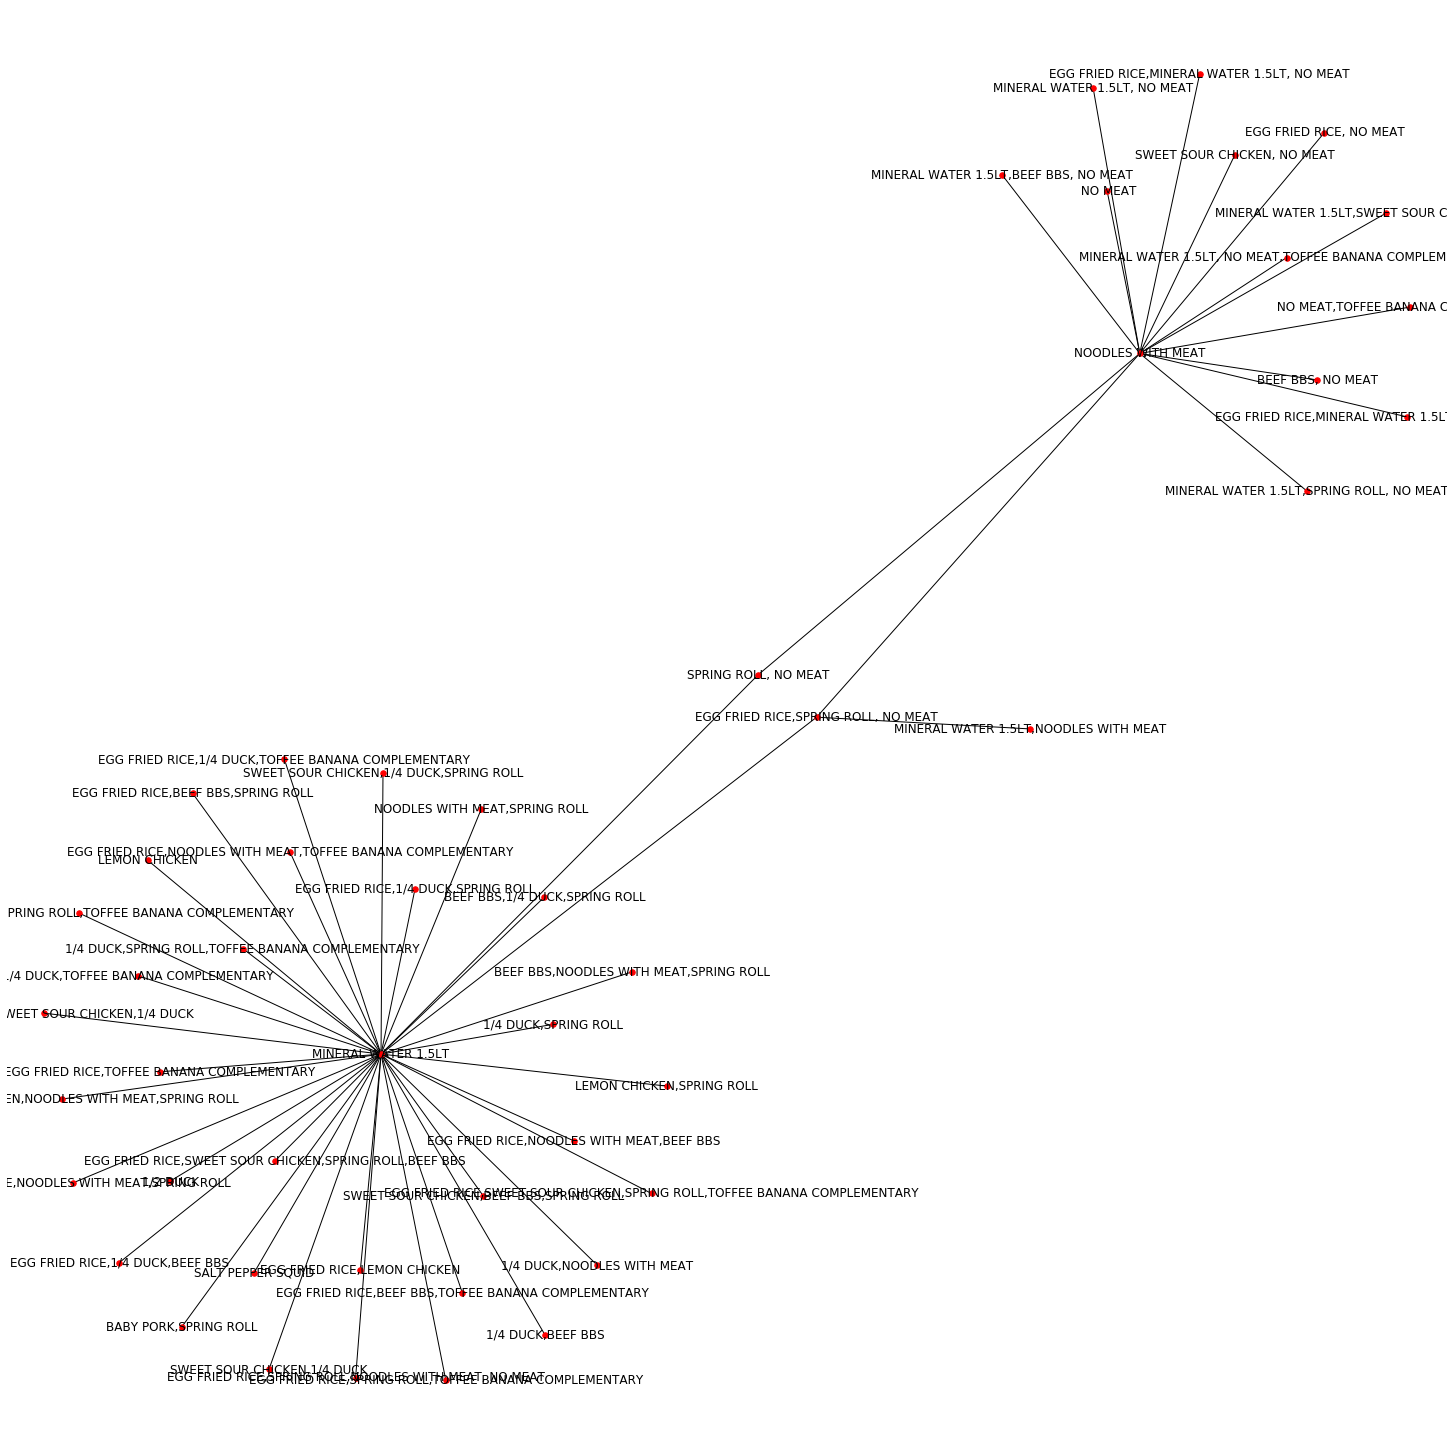

In [126]:
### Plot a basic network graph of the top 50 confidence rules 

# Create a copy of the rules and transform the frozensets to strings 

rulesToPlot_rest = rulesConfidence_rest.copy(deep=True) 

rulesToPlot_rest['LHS'] = [','.join(list(x)) for x in rulesToPlot_rest['antecedents']] 

rulesToPlot_rest['RHS'] = [','.join(list(x)) for x in rulesToPlot_rest['consequents']] 

# Remove duplicate if reversed rules 

rulesToPlot_rest['sortedRow'] = [sorted([a,b]) for a,b in zip(rulesToPlot_rest.LHS, rulesToPlot_rest.RHS)] 

rulesToPlot_rest['sortedRow'] = rulesToPlot_rest['sortedRow'].astype(str) 

rulesToPlot_rest.drop_duplicates(subset=['sortedRow'], inplace=True) 

# Plot 

rulesToPlot_rest=rulesToPlot_rest[:50] 

fig = plt.figure(figsize=(20, 20))  

G = nx.from_pandas_edgelist(rulesToPlot_rest, 'LHS', 'RHS') 

nx.draw(G, with_labels=True, node_size=30, node_color="red", pos=nx.spring_layout(G), seed=1234) 

plt.axis('equal') 

plt.show() 

## Interpretation:

In this network graph it's represented the Confidence association rule in our products, we can see 2 major groups centered in **Mineral Water** and **Noodle with meat** wich means they are the most frequent consequents, the dots closer to wich point refers to the most frequent antecendes of wich point. Closer the point more Confidence has. The ones in between means they are equally found with both consequents.

In [121]:
#Without water
frequent_itemsets = apriori(pt_rest_NW, min_support=0.05, use_colnames=True) 

rulesConfidence_rest = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.50) 
rulesConfidence_rest.sort_values(by='confidence', ascending=False, inplace=True) 
print(rulesConfidence_rest.head(10))

rulesSupport_rest = association_rules(frequent_itemsets, metric="support", min_threshold=0.20) 
rulesSupport_rest.sort_values(by='support', ascending=False, inplace=True) 
print(rulesSupport_rest.head(10)) 

 
rulesLift_rest = association_rules(frequent_itemsets, metric="lift", min_threshold=0) #Change to 0 so we can look into substitute products 
rulesLift_rest.sort_values(by='lift', ascending=False, inplace=True) 
rulesLift_rest.head(10) 

                                     antecedents          consequents  \
35                          (BEEF BBS,  NO MEAT)  (NOODLES WITH MEAT)   
52       ( NO MEAT, TOFFEE BANANA COMPLEMENTARY)  (NOODLES WITH MEAT)   
2                                     ( NO MEAT)  (NOODLES WITH MEAT)   
38                    (EGG FRIED RICE,  NO MEAT)  (NOODLES WITH MEAT)   
44                       (SPRING ROLL,  NO MEAT)  (NOODLES WITH MEAT)   
97       (EGG FRIED RICE, SPRING ROLL,  NO MEAT)  (NOODLES WITH MEAT)   
48                (SWEET SOUR CHICKEN,  NO MEAT)  (NOODLES WITH MEAT)   
5                                     (1/2 DUCK)     (EGG FRIED RICE)   
103  (SWEET SOUR CHICKEN, BEEF BBS, SPRING ROLL)     (EGG FRIED RICE)   
67                (SWEET SOUR CHICKEN, BEEF BBS)     (EGG FRIED RICE)   

     antecedent support  consequent support   support  confidence      lift  \
35             0.052707            0.183758  0.052707    1.000000  5.441941   
52             0.056847            0.1

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
302,"(EGG FRIED RICE, NO MEAT)","(NOODLES WITH MEAT, SPRING ROLL)",0.077707,0.115605,0.055573,0.715164,6.186267,0.046590,3.104926
303,"(NOODLES WITH MEAT, SPRING ROLL)","(EGG FRIED RICE, NO MEAT)",0.115605,0.077707,0.055573,0.480716,6.186267,0.046590,1.776087
125,( NO MEAT),"(NOODLES WITH MEAT, SPRING ROLL)",0.123885,0.115605,0.087102,0.703085,6.081781,0.072780,2.978611
124,"(NOODLES WITH MEAT, SPRING ROLL)",( NO MEAT),0.115605,0.123885,0.087102,0.753444,6.081781,0.072780,3.553404
296,"(EGG FRIED RICE, NOODLES WITH MEAT, SPRING ROLL)",( NO MEAT),0.074682,0.123885,0.055573,0.744136,6.006654,0.046321,3.424148
309,( NO MEAT),"(EGG FRIED RICE, NOODLES WITH MEAT, SPRING ROLL)",0.123885,0.074682,0.055573,0.448586,6.006654,0.046321,1.678083
77,(JIRA PULAO),(NAAN),0.105414,0.117834,0.073567,0.697885,5.922593,0.061145,2.919968
76,(NAAN),(JIRA PULAO),0.117834,0.105414,0.073567,0.624324,5.922593,0.061145,2.381272
138,( NO MEAT),"(NOODLES WITH MEAT, TOFFEE BANANA COMPLEMENTARY)",0.123885,0.077707,0.056847,0.458869,5.905116,0.047220,1.704380
135,"(NOODLES WITH MEAT, TOFFEE BANANA COMPLEMENTARY)",( NO MEAT),0.077707,0.123885,0.056847,0.731557,5.905116,0.047220,3.263694


/Users/anaalferes/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning:


The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.



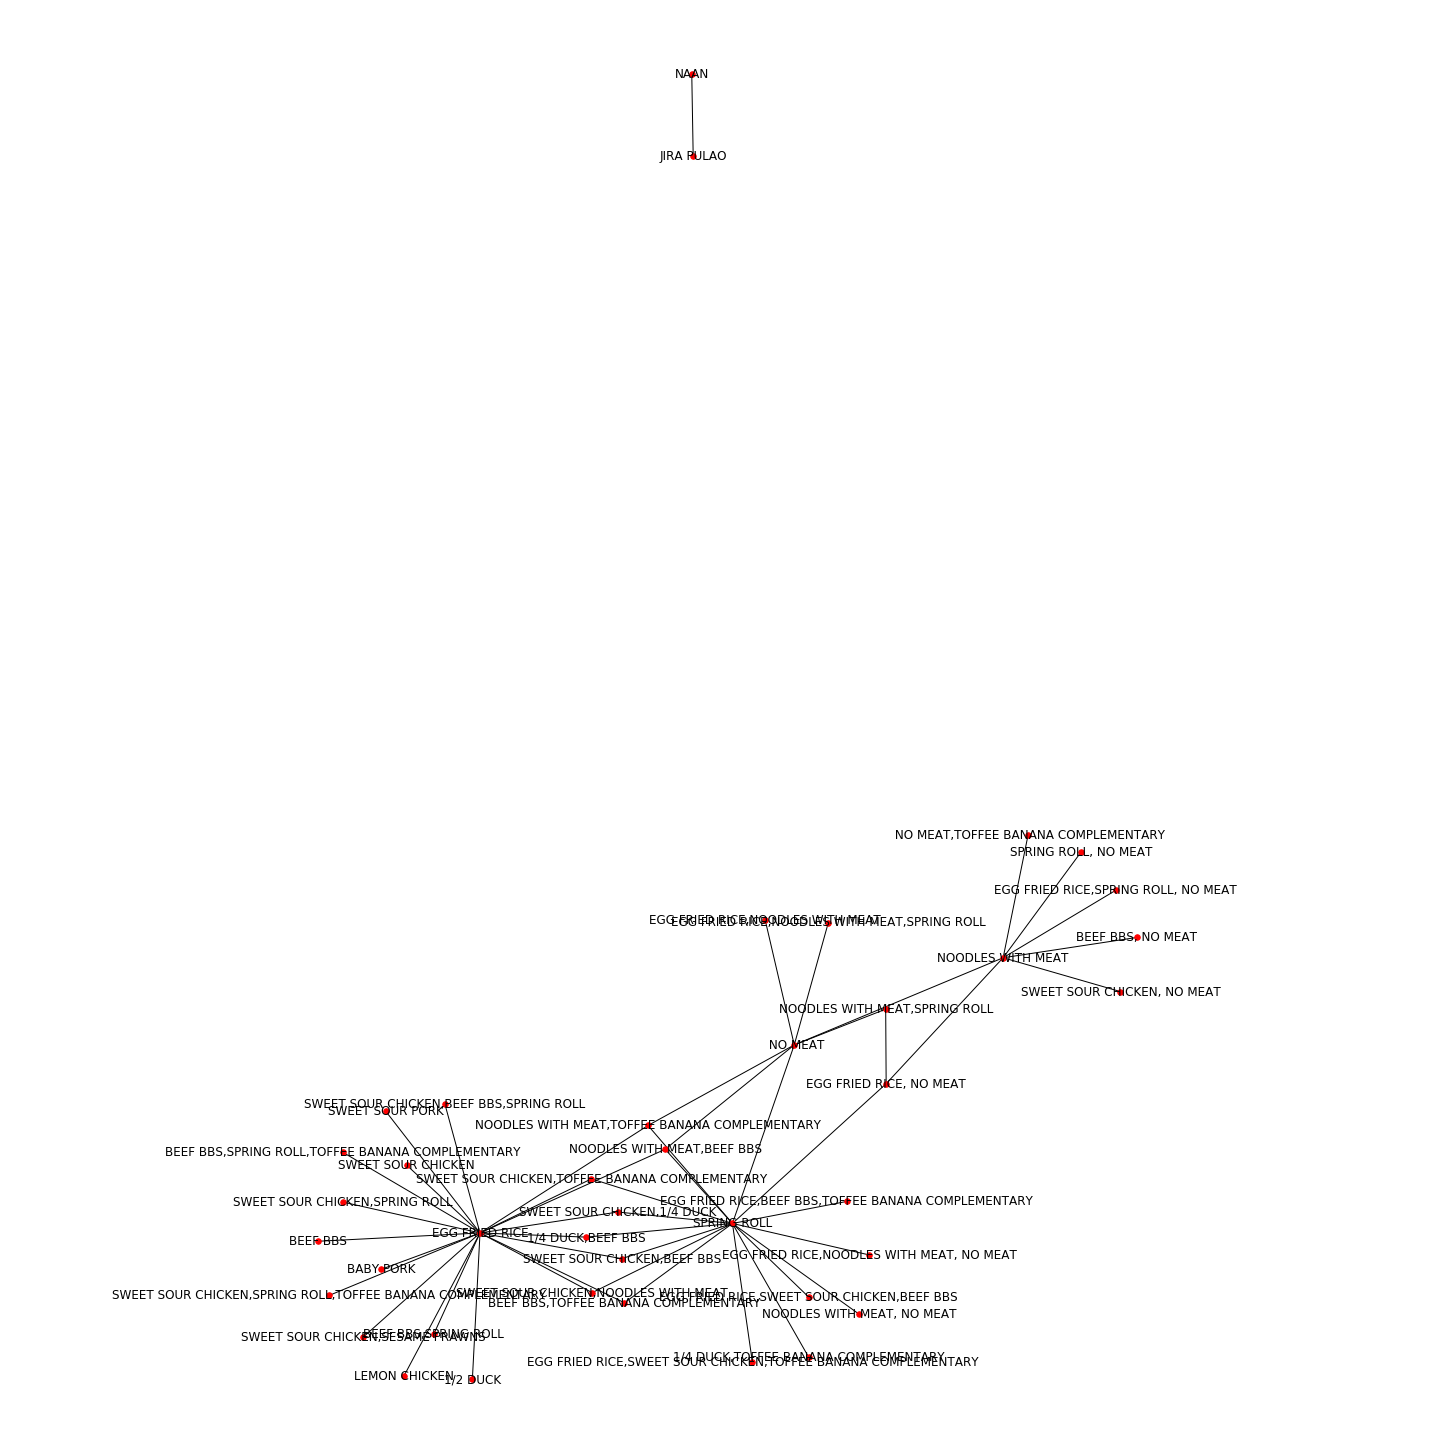

In [122]:
### Plot a basic network graph of the top 50 confidence rules 

# Create a copy of the rules and transform the frozensets to strings 

rulesToPlot_rest = rulesConfidence_rest.copy(deep=True) 

rulesToPlot_rest['LHS'] = [','.join(list(x)) for x in rulesToPlot_rest['antecedents']] 

rulesToPlot_rest['RHS'] = [','.join(list(x)) for x in rulesToPlot_rest['consequents']] 

# Remove duplicate if reversed rules 

rulesToPlot_rest['sortedRow'] = [sorted([a,b]) for a,b in zip(rulesToPlot_rest.LHS, rulesToPlot_rest.RHS)] 

rulesToPlot_rest['sortedRow'] = rulesToPlot_rest['sortedRow'].astype(str) 

rulesToPlot_rest.drop_duplicates(subset=['sortedRow'], inplace=True) 

# Plot 

rulesToPlot_rest=rulesToPlot_rest[:50] 

fig = plt.figure(figsize=(20, 20))  

G = nx.from_pandas_edgelist(rulesToPlot_rest, 'LHS', 'RHS') 

nx.draw(G, with_labels=True, node_size=30, node_color="red", pos=nx.spring_layout(G), seed=1234) 

plt.axis('equal') 

plt.show() 

## Interpretation:

In this network graph it's represented the Confidence association rule in our products, we can see 2 major groups centered in **Egg Fried Rice** and **Spring Roll** wich means they are the most frequent consequents, the dots closer to wich point refers to the most frequent antecendes of wich point. Closer the point more Confidence has.  The ones in between means they are equally found with both consequents.
In this one we can also see 3 minor groups, 2 of them centered in **Noodles with meat** and **No meat**, and a smaller group with just 2 products far way from the others wich means they don't usually get ordered with other products.

### New Product Ideas for Restaurants

In [100]:
#General exploration of high confidence and high lift: 
rulesConfidence_rest[(rulesConfidence_rest['confidence'] >= 0.5) & (rulesConfidence_rest['lift'] >= 4)] 

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
35,"(BEEF BBS, NO MEAT)",(NOODLES WITH MEAT),0.052707,0.183758,0.052707,1.000000,5.441941,0.043022,inf
52,"( NO MEAT, TOFFEE BANANA COMPLEMENTARY)",(NOODLES WITH MEAT),0.056847,0.183758,0.056847,1.000000,5.441941,0.046401,inf
2,( NO MEAT),(NOODLES WITH MEAT),0.123885,0.183758,0.123885,1.000000,5.441941,0.101120,inf
38,"(EGG FRIED RICE, NO MEAT)",(NOODLES WITH MEAT),0.077707,0.183758,0.077707,1.000000,5.441941,0.063428,inf
44,"(SPRING ROLL, NO MEAT)",(NOODLES WITH MEAT),0.087102,0.183758,0.087102,1.000000,5.441941,0.071096,inf
97,"(EGG FRIED RICE, SPRING ROLL, NO MEAT)",(NOODLES WITH MEAT),0.055573,0.183758,0.055573,1.000000,5.441941,0.045361,inf
48,"(SWEET SOUR CHICKEN, NO MEAT)",(NOODLES WITH MEAT),0.064968,0.183758,0.064968,1.000000,5.441941,0.053030,inf
45,"(NOODLES WITH MEAT, SPRING ROLL)",( NO MEAT),0.115605,0.123885,0.087102,0.753444,6.081781,0.072780,3.553404
95,"(EGG FRIED RICE, NOODLES WITH MEAT, SPRING ROLL)",( NO MEAT),0.074682,0.123885,0.055573,0.744136,6.006654,0.046321,3.424148
51,"(NOODLES WITH MEAT, TOFFEE BANANA COMPLEMENTARY)",( NO MEAT),0.077707,0.123885,0.056847,0.731557,5.905116,0.047220,3.263694


### First Interpretation:
**NO MEAT -> NOODLES WITH MEAT (Index 2)**

High Lift means complementary effects. Under the assumption that no meat is not a product but an additional item for an item with meat: People like to eat noodles with meat but also without meat. Confidence of 1 means that if customers “ordered” the item “No Meat” they also ordered “Noodles with meat”.

**SPRING ROLL  -> EGG FRIED RICE (No Water DATA)**
High Confidence (=62%) and Support (=22%) which means they are items that are often ordered together. Since "Spring Roll" it's a started and "Egg Fried Rice" a side dish ir order to be a complete meal we need at least 1 more products

**SWEET SOUR CHICKEN  -> EGG FRIED RICE (No Water DATA)**
High Confidence (=71%) and Support (=21%). Since "SWEET SOUR CHICKEN" it's a just meat and "Egg Fried Rice" a side dish, this tow combined make a main dish.

Maybe consider the hypotheses of making a menu with **SPRING ROLL, SWEET SOUR CHICKEN & EGG FRIED RICE**

**In general** within the restaurants most combinations represents menues. That is why new menues, including a drink, should be taken into account.

For further analysis and interpretation please consult our report.

### Substitute Products in Restaurants

In [101]:
rulesLift_rest[rulesLift_rest.lift<1]

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction


Comments about substitute products here

### Modelling for Deliveries

In [102]:
frequent_itemsets = apriori(pt_deli, min_support=0.05, use_colnames=True) 

rulesConfidence_deli = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.50) 
rulesConfidence_deli.sort_values(by='confidence', ascending=False, inplace=True) 
print(rulesConfidence_deli.head(10)) 

rulesSupport_deli = association_rules(frequent_itemsets, metric="support", min_threshold=0.20) 
rulesSupport_deli.sort_values(by='support', ascending=False, inplace=True) 
print(rulesSupport_deli.head(10)) 

 
rulesLift_deli = association_rules(frequent_itemsets, metric="lift", min_threshold=0) 
rulesLift_deli.sort_values(by='lift', ascending=False, inplace=True) 
rulesLift_deli.head(10) 

                          antecedents          consequents  \
2                          ( NO MEAT)  (NOODLES WITH MEAT)   
1                   ( EXTRA PANCAKES)       ( EXTRA SAUCE)   
0                      ( EXTRA SAUCE)    ( EXTRA PANCAKES)   
14     (SWEET SOUR CHICKEN, 1/4 DUCK)     (EGG FRIED RICE)   
9                (SWEET SOUR CHICKEN)     (EGG FRIED RICE)   
19       (SWEET SOUR CHICKEN, TSANTA)     (EGG FRIED RICE)   
16  (SWEET SOUR CHICKEN, SPRING ROLL)     (EGG FRIED RICE)   
5                     (LEMON CHICKEN)     (EGG FRIED RICE)   
4                          (BEEF BBS)     (EGG FRIED RICE)   
12            (1/4 DUCK, SPRING ROLL)     (EGG FRIED RICE)   

    antecedent support  consequent support   support  confidence      lift  \
2             0.062474            0.125976  0.062474    1.000000  7.938010   
1             0.085491            0.090423  0.063913    0.747596  8.267734   
0             0.090423            0.085491  0.063913    0.706818  8.267734   
14   

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,( EXTRA SAUCE),( EXTRA PANCAKES),0.090423,0.085491,0.063913,0.706818,8.267734,0.056182,3.119255
1,( EXTRA PANCAKES),( EXTRA SAUCE),0.085491,0.090423,0.063913,0.747596,8.267734,0.056182,3.603656
2,(NOODLES WITH MEAT),( NO MEAT),0.125976,0.062474,0.062474,0.495922,7.938010,0.054604,1.859881
3,( NO MEAT),(NOODLES WITH MEAT),0.062474,0.125976,0.062474,1.000000,7.938010,0.054604,inf
44,(NAAN),(JIRA PULAO),0.119400,0.097205,0.052815,0.442341,4.550593,0.041209,1.618901
45,(JIRA PULAO),(NAAN),0.097205,0.119400,0.052815,0.543340,4.550593,0.041209,1.928351
77,"(EGG FRIED RICE, 1/4 DUCK)",(SWEET SOUR CHICKEN),0.126798,0.335799,0.070695,0.557536,1.660326,0.028116,1.501142
80,(SWEET SOUR CHICKEN),"(EGG FRIED RICE, 1/4 DUCK)",0.335799,0.126798,0.070695,0.210526,1.660326,0.028116,1.106056
79,(EGG FRIED RICE),"(SWEET SOUR CHICKEN, 1/4 DUCK)",0.412659,0.105220,0.070695,0.171315,1.628159,0.027275,1.079759
78,"(SWEET SOUR CHICKEN, 1/4 DUCK)",(EGG FRIED RICE),0.105220,0.412659,0.070695,0.671875,1.628159,0.027275,1.789991


/Users/anaalferes/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning:


The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.



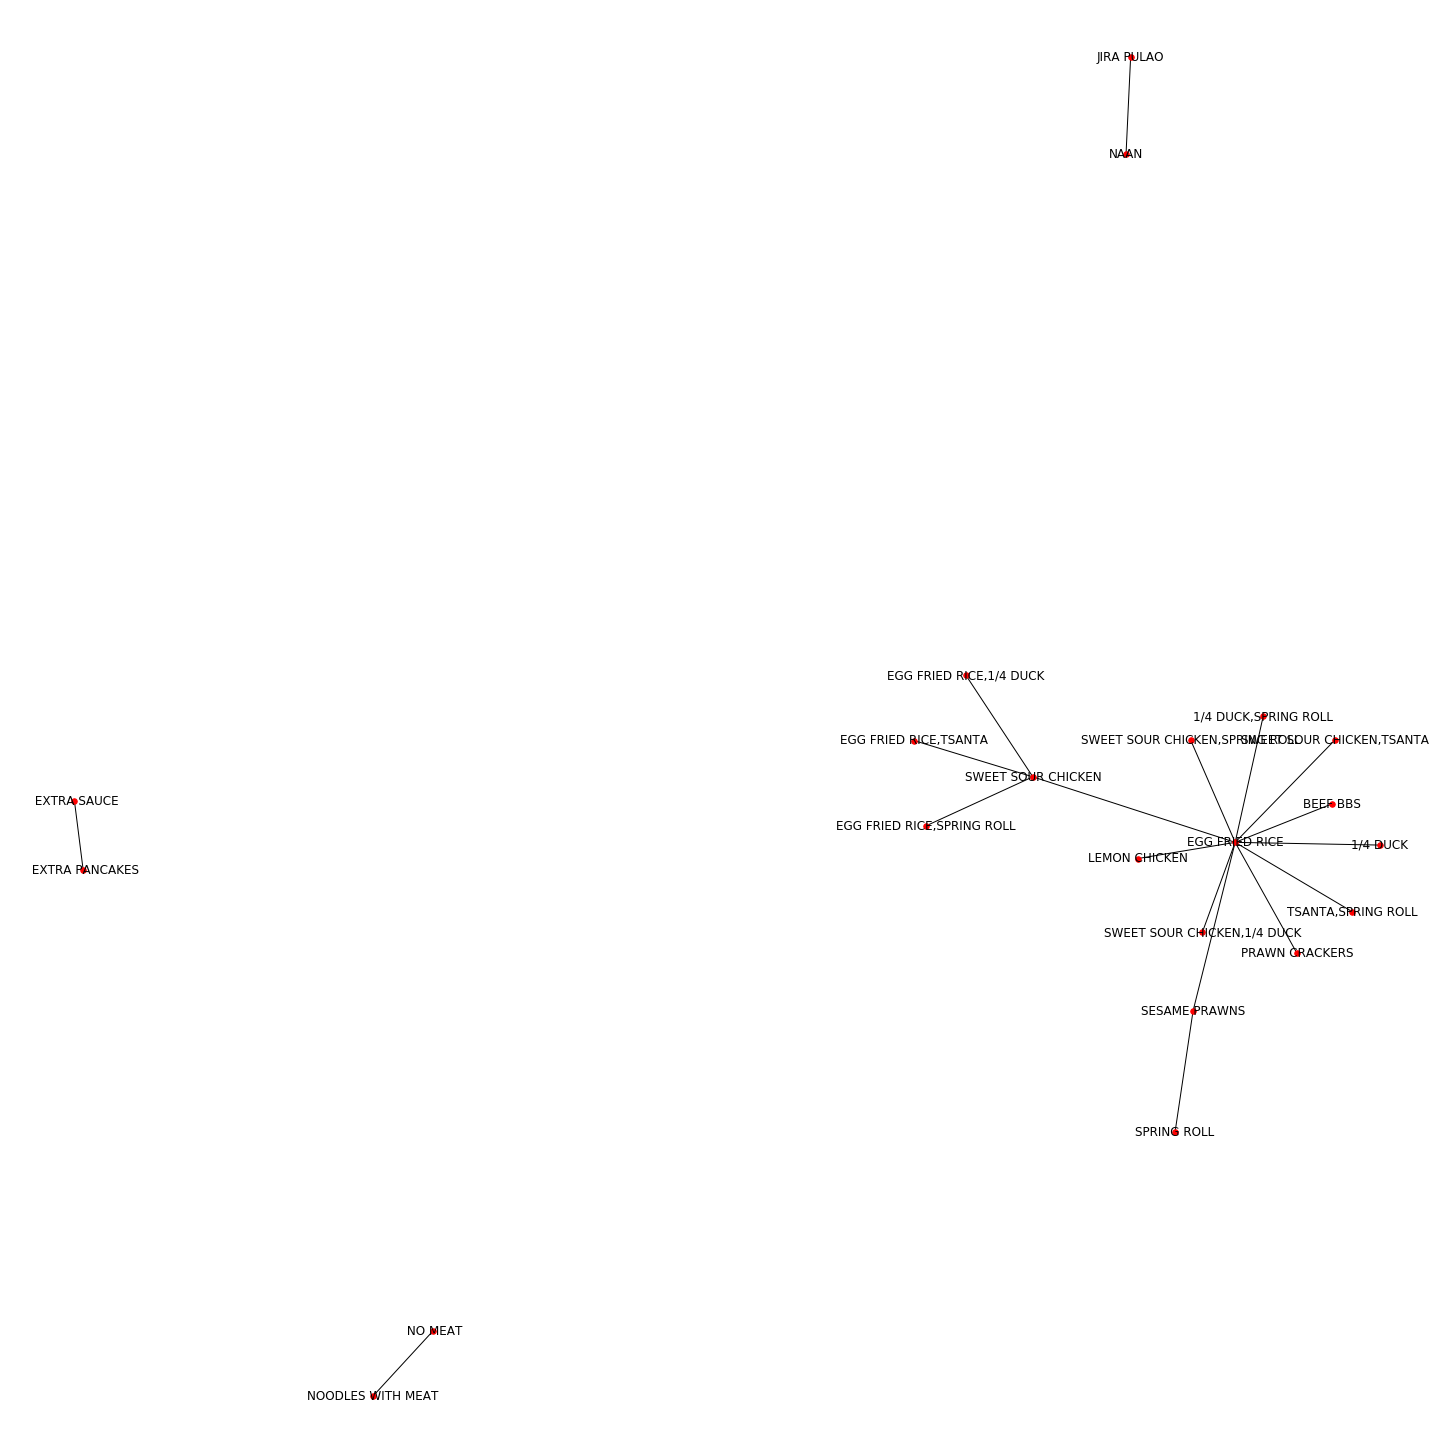

In [103]:
### Plot a basic network graph of the top 50 confidence rules 

# Create a copy of the rules and transform the frozensets to strings 

rulesToPlot_deli = rulesConfidence_deli.copy(deep=True) 

rulesToPlot_deli['LHS'] = [','.join(list(x)) for x in rulesToPlot_deli['antecedents']] 

rulesToPlot_deli['RHS'] = [','.join(list(x)) for x in rulesToPlot_deli['consequents']] 

# Remove duplicate if reversed rules 

rulesToPlot_deli['sortedRow'] = [sorted([a,b]) for a,b in zip(rulesToPlot_deli.LHS, rulesToPlot_deli.RHS)] 

rulesToPlot_deli['sortedRow'] = rulesToPlot_deli['sortedRow'].astype(str) 

rulesToPlot_deli.drop_duplicates(subset=['sortedRow'], inplace=True) 

# Plot 

rulesToPlot_deli=rulesToPlot_deli[:50] 

fig = plt.figure(figsize=(20, 20))  

G = nx.from_pandas_edgelist(rulesToPlot_deli, 'LHS', 'RHS') 

nx.draw(G, with_labels=True, node_size=30, node_color="red", pos=nx.spring_layout(G), seed=1234) 

plt.axis('equal') 

plt.show() 

## Interpretation:

In this network graph it's represented the Confidence association rule in our products, we can see 2 groups centered in **Egg Fried Rice** and **Sweet Sour Chiken** wich means they are the most frequent consequents, the dots closer to wich point refers to the most frequent antecendes of wich point. Closer the point more Confidence has. We can also see that the center are connected, this means they are also usually order together.
It's also visible 3 small groups composed just with 2 products each one, this means they are most of the time not ordered with other products.

### New Product Ideas for Deliveries

In [104]:
#General exploration of high confidence and high lift: 
rulesConfidence_deli[(rulesConfidence_deli['confidence'] >= 0.5) & (rulesConfidence_deli['lift'] >= 4)]

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
2,( NO MEAT),(NOODLES WITH MEAT),0.062474,0.125976,0.062474,1.000000,7.938010,0.054604,inf
1,( EXTRA PANCAKES),( EXTRA SAUCE),0.085491,0.090423,0.063913,0.747596,8.267734,0.056182,3.603656
0,( EXTRA SAUCE),( EXTRA PANCAKES),0.090423,0.085491,0.063913,0.706818,8.267734,0.056182,3.119255
10,(JIRA PULAO),(NAAN),0.097205,0.119400,0.052815,0.543340,4.550593,0.041209,1.928351


### First Interpretation:
**NO MEAT -> NOODLES WITH MEAT (Index 2)**

High Lift (=7.9) means complementary effects. Under the assumption that no meat is not a product but an additional item for an item with meat: People like to eat noodles with meat (support of 12.6 %) but also without meat (support of 6.2 %). Confidence of 1 means that if customers “ordered” the item “No Meat” they also ordered “Noodles with meat”. 

**JIRA PULAU -> NAAN (Index 10)**

A rather high lift (=4.6): complementary effects. Furthermore, both a side dishes or starters.


**SWEET SOUR CHICKEN  -> EGG FRIED RICE (No Water DATA)**

Confidence (=62%) and Support (=22%) high, we can consider a special menu for this order.

For further analysis and interpretation please consult our report.

### Substitute Products in Deliveries

In [105]:
rulesLift_deli[rulesLift_deli.lift<=1] #No substitute products in Deliveries

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction


Comments about substitute products here

### Recommendation system 
#### for restaurants 
First filter dataset by features isDinner, Pax (binned) and isHoliday, then recommend product with highest lift based the ordered items of customer.


In [106]:
# Change dtype to datetime
df.InvoiceDateHour = pd.to_datetime(df.InvoiceDateHour, format='%Y-%m-%d %H:%M:%S.%f')
# Mark order as dinner if invoice hour bigger 17
df["isDinner"] = [0 if x.hour < 17 else 1 for x in df.InvoiceDateHour]

# Bin pax
df["PaxBinned"] = ["1-2" if x <= 2 else "3-5" if x <=5 else "6+" for x in df.Pax ]

# isHoliday
df["isHoliday"] = [0 if x == "No Holiday" else 1 for x in df.Name]

In [107]:
# Check sizes of customer segments
df_res = df[df.IsDelivery == 0]
pd.crosstab(df_res.PaxBinned,[df_res.isDinner, df_res.isHoliday])

isDinner      0           1     
isHoliday     0    1      0    1
PaxBinned                       
1-2         991   80  13480  560
3-5        2764  411  20259  710
6+         2204  442  10629  636

In [108]:
# Helping functions 

# This function returns the transactions dataseet filtered by restaurant customers, pax, isHoliday and isDinner
def filter_df_pax(pax):
    # Get current time and check if dinner
    is_dinner = 1
    if dt.datetime.now().hour < 17:
        is_dinner = 1
        
    # Get current date and check if holiday
    is_holiday = 0
    if len(holidays[(holidays.Month == dt.datetime.now().month) & (holidays.Day == dt.datetime.now().day)]) != 0:
        is_holiday = 1
    
    # Get bin for pax
    if pax <= 2: 
        bin_pax = "1-2"
    elif pax <= 5:
        bin_pax = "3-5"
    else:
        bin_pax = "6+"
    
    # Filter dataset 
    df_rec = df[(df.IsDelivery == 0) & (df.isDinner == is_dinner) & (df.isHoliday == is_holiday) & (df.PaxBinned == bin_pax)].copy(deep=True)
    
    return df_rec

# This function returns a list of alphabetically sorted strings with all possible itemset combinations
def get_itemsstrings(items):
     # Get all possible combinations as a list of tuples
    itemsets = []
    for i in range(1,len(items) + 1):
        for i in itertools.combinations(items, i):
            itemsets.append(i)

    # Transform tuples into list of strings, sort the list alphabetically and create string out of sorted list 
    itemslists = [list(x) for x in itemsets]
    for i in itemslists:
        i.sort()
    itemsstrings = [" ".join(x) for x in itemslists]
    return itemsstrings

# This functions returns a dataframe with rules, based on the df returned by filter_df(pax)
def get_rules(pax, support_min, confidence_min):
    
    # Create frequent itemset of filtered df
    pt_rec = pd.pivot_table(filter_df_pax(pax)[["DocNumber","ProductDesignation"]], index='DocNumber', columns='ProductDesignation', aggfunc=lambda x: 1 if len(x)>0 else 0).fillna(0) 
    frequent_itemsets = apriori(pt_rec, min_support=support_min, use_colnames=True) 
    rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=confidence_min)
    
    # Remove duplicate if reversed rules
    rules['LHS'] = [','.join(list(x)) for x in rules['antecedents']]
    rules['RHS'] = [','.join(list(x)) for x in rules['consequents']]
    rules['sortedRow'] = [sorted([a,b]) for a,b in zip(rules.LHS, rules.RHS)]
    rules['sortedRow'] = rules['sortedRow'].astype(str)
    rules.drop_duplicates(subset=['sortedRow'], inplace=True)

    # Transform antecedents and consequents into list of strings, sort the list alphabetically and create string out of sorted list 
    rules["antecedents"] = rules["antecedents"].apply(lambda x: list(x))
    rules["consequents"] = rules["consequents"].apply(lambda x: list(x))

    for i in rules.index.values:
        rules.loc[i,"antecedents"].sort()
        rules.loc[i,"consequents"].sort()

    rules["antecedents"] = rules["antecedents"].apply(lambda x: " ".join(x))
    rules["consequents"] = rules["consequents"].apply(lambda x: " ".join(x))

    # Remove space in the beginning of antecedents and consequents
    rules["antecedents"] = rules["antecedents"].apply(lambda x: x[1:] if x[0] == " " else x)
    rules["consequents"] = rules["consequents"].apply(lambda x: x[1:] if x[0] == " " else x)
    
    return rules

In [109]:
# Get recommended products 
# Based on items (list of strings) as antecendents returns maximum 10 itemsets with the highest lift

def get_recommendation_rest(pax, items, support_min=0.03, confidence_min=0.1, lift_min=1.1):
    itemsstrings = get_itemsstrings(items)
    rules = get_rules(pax, support_min, confidence_min)
    
    # Filter possible recommendations
    recoms = rules[rules.antecedents.isin(itemsstrings)]
    # Sort by lift and select relevant information of top ten
    top_ten = recoms.sort_values("lift", ascending=False)[:10][["antecedents", "consequents", "support", "confidence", "lift"]]
    
    # Only consider rules with certain lift 
    top_ten = top_ten[top_ten.lift >= lift_min]
    
    return top_ten

In [110]:
get_recommendation_rest(2, ["NAAN", "SWEET SOUR CHICKEN", "COKE ZERO", "EGG FRIED RICE"])


,antecedents,consequents,support,confidence,lift
74,NAAN,JIRA PULAO,0.058673,0.621622,6.929166
61,EGG FRIED RICE,SWEET SOUR CHICKEN,0.164966,0.551136,2.242686
21,EGG FRIED RICE,BEEF BBS,0.072704,0.242898,2.155832
51,EGG FRIED RICE,LEMON CHICKEN,0.046769,0.156250,2.076271
309,EGG FRIED RICE SWEET SOUR CHICKEN,1/6 DUCK MINERAL WATER 1.5LT,0.062925,0.381443,2.067177
131,EGG FRIED RICE SWEET SOUR CHICKEN,1/6 DUCK,0.068878,0.417526,2.028968
232,EGG FRIED RICE SWEET SOUR CHICKEN,SESAME PRAWNS,0.031888,0.193299,1.959652
16,SWEET SOUR CHICKEN,1/6 DUCK,0.098214,0.399654,1.942120
101,SWEET SOUR CHICKEN,SESAME PRAWNS,0.045918,0.186851,1.894285
6,EGG FRIED RICE,1/6 DUCK,0.112670,0.376420,1.829217


#### for deliveries 
First filter dataset by features isDinner, isHoliday and Location, then recommend product with highest lift based the ordered items of customer.

In [111]:
# Change dtype to datetime
df.InvoiceDateHour = pd.to_datetime(df.InvoiceDateHour, format='%Y-%m-%d %H:%M:%S.%f')
# Mark order as dinner if invoice hour bigger 17
df["isDinner"] = [0 if x.hour < 17 else 1 for x in df.InvoiceDateHour]

# isHoliday
df["isHoliday"] = [0 if x == "No Holiday" else 1 for x in df.Name]

In [112]:
# Check sizes of customer segments
df_del = df[df.IsDelivery == 1]
pd.crosstab(df_del.CustomerCity,[df_del.isDinner, df_del.isHoliday])
# for the prototype we only use the location feature, if there are more than 75 datapoints in the field

isDinner            0         1     
isHoliday           0   1     0    1
CustomerCity                        
AGIOS DOMETIOS     27   0  1242   29
AGLANTZIA          12   0   983   47
DALI               47  13   613   36
EGKOMI            732  69  7886  799
GERI                0   0     7   11
LAKATAME            0   0    52    0
LAKATAMEIA         75  11  4426  208
LATSIA              5   0   595   23
LEYKOSIA          197   8  3713  266
NICOSIA           108  36  1870   67
PANO DEYTERA        0   0    14    0
STROBOLOS         195  20  6384  483
SYN. ANTHOYPOLIS    0   0    14    5
TSERI               0   0    62    0

In [113]:
# Helping functions 

# This function returns the transactions dataseet filtered by delivery customers, city, isHoliday and isDinner
def filter_df_city(city):
    # Get current time and check if dinner
    is_dinner = 1
    if dt.datetime.now().hour < 17:
        is_dinner = 1
        
    # Get current date and check if holiday
    is_holiday = 0
    if len(holidays[(holidays.Month == dt.datetime.now().month) & (holidays.Day == dt.datetime.now().day)]) != 0:
        is_holiday = 1

    
    # Filter dataset 
    df_rec = df[(df.IsDelivery == 1) & (df.isDinner == is_dinner) & (df.isHoliday == is_holiday) & (df.CustomerCity == city)].copy(deep=True)
    if len(df_rec.index.values) > 75:
        return df_rec
    else: 
        return df[(df.IsDelivery == 1) & (df.isDinner == is_dinner) & (df.isHoliday == is_holiday)].copy(deep=True)

# This function returns a list of alphabetically sorted strings with all possible itemset combinations
def get_itemsstrings(items):
     # Get all possible combinations as a list of tuples
    itemsets = []
    for i in range(1,len(items) + 1):
        for i in itertools.combinations(items, i):
            itemsets.append(i)

    # Transform tuples into list of strings, sort the list alphabetically and create string out of sorted list 
    itemslists = [list(x) for x in itemsets]
    for i in itemslists:
        i.sort()
    itemsstrings = [" ".join(x) for x in itemslists]
    return itemsstrings

# This functions returns a dataframe with rules, based on the df returned by filter_df(city)
def get_rules_deli(city, support_min, confidence_min):
    
    # Create frequent itemset of filtered df
    pt_rec = pd.pivot_table(filter_df_city(city)[["DocNumber","ProductDesignation"]], index='DocNumber', columns='ProductDesignation', aggfunc=lambda x: 1 if len(x)>0 else 0).fillna(0) 
    frequent_itemsets = apriori(pt_rec, min_support=support_min, use_colnames=True) 
    rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=confidence_min)
    
    # Remove duplicate if reversed rules
    rules['LHS'] = [','.join(list(x)) for x in rules['antecedents']]
    rules['RHS'] = [','.join(list(x)) for x in rules['consequents']]
    rules['sortedRow'] = [sorted([a,b]) for a,b in zip(rules.LHS, rules.RHS)]
    rules['sortedRow'] = rules['sortedRow'].astype(str)
    rules.drop_duplicates(subset=['sortedRow'], inplace=True)

    # Transform antecedents and consequents into list of strings, sort the list alphabetically and create string out of sorted list 
    rules["antecedents"] = rules["antecedents"].apply(lambda x: list(x))
    rules["consequents"] = rules["consequents"].apply(lambda x: list(x))

    for i in rules.index.values:
        rules.loc[i,"antecedents"].sort()
        rules.loc[i,"consequents"].sort()

    rules["antecedents"] = rules["antecedents"].apply(lambda x: " ".join(x))
    rules["consequents"] = rules["consequents"].apply(lambda x: " ".join(x))

    # Remove space in the beginning of antecedents and consequents
    rules["antecedents"] = rules["antecedents"].apply(lambda x: x[1:] if x[0] == " " else x)
    rules["consequents"] = rules["consequents"].apply(lambda x: x[1:] if x[0] == " " else x)
    
    return rules

In [114]:
# Get recommended products 
# Based on items (list of strings) as antecendents returns maximum 10 itemsets with the highest lift

def get_recommendation_deli(city, items, support_min=0.03, confidence_min=0.1, lift_min=1.1):
    itemsstrings = get_itemsstrings(items)
    rules = get_rules_deli(city, support_min, confidence_min)
    
    # Filter possible recommendations
    recoms = rules[rules.antecedents.isin(itemsstrings)]
    # Sort by lift and select relevant information of top ten
    top_ten = recoms.sort_values("lift", ascending=False)[:10][["antecedents", "consequents", "support", "confidence", "lift"]]
    
    # Only consider rules with certain lift 
    top_ten = top_ten[top_ten.lift >= lift_min]
    
    return top_ten

In [115]:
get_recommendation_deli("EGKOMI", ["NAAN", "SWEET SOUR CHICKEN", "COKE ZERO", "EGG FRIED RICE"])

,antecedents,consequents,support,confidence,lift
133,NAAN,JIRA PULAO,0.051101,0.445205,4.494455
127,EGG FRIED RICE,SWEET SOUR CHICKEN,0.215409,0.527938,1.576379
62,EGG FRIED RICE,BEEF BBS,0.107704,0.263969,1.540224
114,EGG FRIED RICE,LEMON CHICKEN,0.062107,0.152216,1.478004
8,SWEET SOUR CHICKEN,EXTRA PANCAKES,0.037736,0.112676,1.447717
129,EGG FRIED RICE,SWEET SOUR PORK,0.042453,0.104046,1.407945
533,EGG FRIED RICE SWEET SOUR CHICKEN,PRAWN CRACKERS,0.051101,0.237226,1.371599
18,SWEET SOUR CHICKEN,EXTRA SAUCE,0.041667,0.124413,1.352594
350,EGG FRIED RICE SWEET SOUR CHICKEN,BEEF BBS,0.049528,0.229927,1.341592
43,SWEET SOUR CHICKEN,1/4 DUCK,0.104560,0.312207,1.328183


Verify repeting customers

In [116]:
#Create a Dataframe with the frequency of each customer
customer_vc = pd.DataFrame(df_deli.CustomerID.value_counts()).reset_index().rename(columns = {"index":"CustomerID","CustomerID":"Frequency"})

In [117]:
#Create a Pivot Table and join the Frequency and take only customers with frq >1
pt_deli_frq = pd.pivot_table( df[df.IsDelivery == 1][["DocNumber","CustomerID","ProductDesignation"]], index=['DocNumber','CustomerID'], columns='ProductDesignation', aggfunc=lambda x: 1 if len(x)>0 else 0).fillna(0) 
pt_deli_frq= pt_deli_frq.groupby("CustomerID").sum()
pt_deli_frq.reset_index(inplace=True)
pt_deli_frq = pt_deli_frq.merge(customer_vc, left_on = "CustomerID", right_on="CustomerID")
pt_deli_frq = pt_deli_frq[pt_deli_frq.Frequency>2]
pt_deli_frq

,CustomerID,EXTRA PANCAKES,EXTRA SALAD,EXTRA SAUCE,NO BEANSPROUTS,NO CHILLY,NO EGG,NO MEAT,NO MUSHROOMS,NO ONION,...,TEMPURA MAKI,TIN JIAN STYLE CHICKEN,TSANTA,VEG BBS,VEG RICE,VOLCANO MAKI,WHOLE DUCK,WINE,YELLOW DAL DHABA,Frequency
7,46,2.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,3
10,56,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,3.0,0.0,1.0,0.0,0.0,0.0,0.0,9
13,91,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,5.0,0.0,2.0,0.0,0.0,0.0,0.0,5
16,116,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,10
19,131,5.0,5.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,5
21,141,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,3
27,211,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,3
28,212,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,3
30,219,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,3
33,232,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,9


In [118]:
#The goal is to see if our customers order the same as before or they like to try new things
#Start by dropping Bags + Delivery Charge + setting id as index
pt_deli_frq.drop(["TSANTA", "DELIVERY CHARGE"], axis=1, inplace=True)
pt_deli_frq.set_index("CustomerID",inplace=True)
pt_deli_frq

,EXTRA PANCAKES,EXTRA SALAD,EXTRA SAUCE,NO BEANSPROUTS,NO CHILLY,NO EGG,NO MEAT,NO MUSHROOMS,NO ONION,NO PORK,...,TANDOORI TRILOGY,TEMPURA MAKI,TIN JIAN STYLE CHICKEN,VEG BBS,VEG RICE,VOLCANO MAKI,WHOLE DUCK,WINE,YELLOW DAL DHABA,Frequency
CustomerID,,,,,,,,,,,,,,,,,,,,,
46,2.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,3
56,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,9
91,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,5
116,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10
131,5.0,5.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5
141,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
211,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
212,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
219,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3


In [119]:
#If a product has the same quantity as frq, it means the customer always orders the same things.  
products = list(pt_deli_frq.columns.values)
products.remove("Frequency")

pt_deli_frq["is_frq"] = pt_deli_frq[products].max(axis=1) #most common product value
pt_deli_frq["is_frq_prod"] = pt_deli_frq[products].idxmax(axis=1) #most common product value item

In [120]:
frq_cust = pt_deli_frq[["Frequency","is_frq","is_frq_prod"]]
frq_cust["result"] = [1 if frq_cust.loc[i,"is_frq"] > 0.5*frq_cust.loc[i,"Frequency"] else 0 for i in frq_cust.index.values]
frq_cust

/Users/anaalferes/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



,Frequency,is_frq,is_frq_prod,result
CustomerID,,,,
46,3,3.0,CALIFORNIA MAKI,1
56,9,8.0,FORTUNE PORK,1
91,5,5.0,EGG FRIED RICE,1
116,10,9.0,1/4 DUCK,1
131,5,5.0,EXTRA PANCAKES,1
141,3,3.0,EGG FRIED RICE,1
211,3,3.0,EGG FRIED RICE,1
212,3,3.0,EGG FRIED RICE,1
219,3,1.0,1/6 DUCK,0


In [45]:
#remove most frequent products ?